# Bootstrap Distance Imposters

This method is novel, so as with all new things it should be taken with a grain of salt. One problem with GI (as discussed in the [GI Notebook](nux_imposters_ngram.ipynb)) is that it can be difficult to interpret at the high confidence end. This method extends the basic idea by measuring a complete _distance distribution_. In general, given a vector distance function $d(x,y)$ and some variables: $x$ an unknown text; $c_i \in C$ a set of candidate documents; and $y_j \in Y$ a set of imposter documents, GI estimates by boostrap the *single probability* that $min(d(x,C)) < min(d(x,Y))$ ('likelihood a candidate is closer than an imposter'). By contrast, this method records at each iteration $D \coloneqq min(d(x,Y)) - min(d(x,C))$ the _distance_ between the closest candidate and the closest imposter. For situations where $x$ is not by the candidate author we would expect $E[D] \approx 0$ (since the candidates are also imposters), whereas if the candidate is the true author the distance distribution will be centred around a positive number (distance to candidate tends to be less than distance to imposter). In situations of mistaken identity, when the true author is actually among the imposters, then $E[D]$ will be significantly below zero--something that is also not visible with GI. For those who desperately crave _p_-values, the probability mass that is less than zero represents the uncertainty.

This seems more (statistically) powerful in this particular application (not here, but in the [poetry analysis](nux_boot_poet.ipynb)), and provides results that are much more interpretable, since results that are simply "1" in GI (a candidate text was closest in every iteration) will now return full distributions, even if every difference > 0.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from ruzicka.BDIVerifier import BDIVerifier

In [2]:
%load_ext rpy2.ipython

## Vectorizing

Here we use 5000 most common 3-, 4-, and 5-grams with the "nini" metric, see the [BCT (ngrams)](./bct_ngram.ipynb) notebook for more information and comparison.

In [3]:
nini_vec = make_pipeline(
    TfidfVectorizer(
        sublinear_tf=True,
        use_idf=False,
        norm="l1",
        analyzer="char",
        ngram_range=(3, 5),
        max_features=5000,
    ),
    FunctionTransformer(lambda x: np.array(x.todense()), accept_sparse=True),
)

In [4]:
vecs = pd.read_csv("elegy_corpus.csv", index_col=0)
non_elegy_vecs = pd.read_csv("non_elegy_corpus.csv", index_col=0)

## Corpus

See [this notebook](build_corpus.ipynb) for corpus creation details. I use Augustan 'short elegy' as elsewhere, but no poem that is less than twenty lines. In addition, I include 200 samples with length $\sim N(80,20)$ drawn from assorted works of epic hexameter.

In [5]:
corpus = pd.concat([vecs, non_elegy_vecs])

In [6]:
test_corpus = corpus[corpus.Author != "ps-Ovid"]
test_corpus = test_corpus[test_corpus.LEN >= 20]
test_corpus

,Author,Work,Poem,LEN,Chunk
0,Ovid,Ep.,Ep. 1,116,hank tua penelope lento tibi mittit ulikse\nni...
1,Ovid,Ep.,Ep. 2,148,hospita demopoon tua te rodopeia pyllis\nultra...
2,Ovid,Ep.,Ep. 3,154,kwam legis a rapta briseide littera wenit\nwik...
3,Ovid,Ep.,Ep. 4,176,kwam nisi tu dederis karitura_st ipsa salutem\...
4,Ovid,Ep.,Ep. 5,158,perlegis an konjunks prohibet nowa perlege non...
...,...,...,...,...,...
195,V.Flaccus,195-Argonautica,195-Argonautica,62,eumenidumkwe komae non tristis ab aetere gorgo...
196,Lucretius,196-DRN,196-DRN,92,kernere koeperunt kontendere _satkwe parare\nn...
197,Horace,197-Hor.,197-Hor. Sat.,72,kwod plakui tibi kwi turpi sekernis honestum\n...
198,Vergil,198-Aeneid,198-Aeneid,79,insinjem gemmis tum fumida lumine fulwo\ninwol...


In [7]:
labels, label_uniques = test_corpus.Author.factorize()

In [8]:
X = nini_vec.fit_transform(test_corpus.Chunk)
y = labels

In [9]:
problems = corpus[corpus.Author == "ps-Ovid"]
probs_X = nini_vec.transform(problems.Chunk)

In [10]:
problems

,Author,Work,Poem,LEN,Chunk
296,ps-Ovid,Nux,Nux,182,nuks ego junkta wiae kum sim sine krimine wita...
297,ps-Ovid,Medicamina,Medicamina,100,diskite kwae fakiem kommendet kura puellae\net...
298,ps-Ovid,Pamphilus,Pamphilus,198,postkwam pampileas rumor perwenit ad aures\ngl...
299,ps-Ovid,Consolatio,Consolatio 1,158,wisa diu feliks mater modo dikta neronum\njam ...
300,ps-Ovid,Consolatio,Consolatio 2,158,at_kwutinam drusi manus alte_ret altera fratri...
301,ps-Ovid,Consolatio,Consolatio 3,158,kwo raperis laniata komas similiskwe furenti\n...
302,ps-Ovid,Ibis,Ibis 1,64,tempus ad hok lustris bis jam mihi kwinkwe per...
303,ps-Ovid,Ibis,Ibis 2,200,di maris et terrae kwi_kwis meliora tenetis\ni...
304,ps-Ovid,Ibis,Ibis 3,200,kwi_kwokulis karuit per kwos male widerat auru...
305,ps-Ovid,Ibis,Ibis 4,178,aut te dewoweat kertis abdera diebus\nsaksakwe...


In [11]:
ss = StandardScaler(with_mean=False).fit(X)
scaled_X = ss.transform(X)
scaled_probs_X = ss.transform(probs_X)
problem_dict = dict(zip(problems.Poem, scaled_probs_X))

## BDI

Now we run the actual method. First we look at the match strength for all the "problem" works (some Ovidian, some not) against every candidate.

In [12]:
# Create the verifier object
rng = np.random.default_rng(42)

bdi_mm = BDIVerifier(
    metric="nini",
    nb_bootstrap_iter=500,
    rnd_prop=0.35,
    random_state=rng,
)

bdi_mm.fit(scaled_X, labels)

In [13]:
# label_uniques is a pandas Index of strings. The numeric labels index into these strings (i.e., they are
# in the same order)
collected = []
for label in label_uniques.values:
    # get_loc gives us the numeric label for a string
    code = label_uniques.get_loc(label)
    # make target labels the same length as the number of problem rows
    res = bdi_mm.predict_proba(
        scaled_probs_X, [code] * scaled_probs_X.shape[0], nb_imposters=75
    )
    collected.append({label: list(zip(res, problems.Poem))})

In [14]:
collected_df = pd.DataFrame()
for d in collected:
    for k, v in d.items():
        vals, idx = zip(*v)
        collected_df[k] = pd.Series(vals, idx)

In [15]:
collected_df

,Ovid,Tibullus,Propertius,Catullus,Baldricus,Radulfus,Vergil,Juvenal,Silius,Statius,Lucan,V.Flaccus,Lucretius,Horace
Nux,0.998,0.070,0.058,0.000,0.006,0.002,0.000,0.060,0.000,0.000,0.006,0.000,0.136,0.024
Medicamina,0.978,0.152,0.562,0.000,0.000,0.012,0.200,0.270,0.032,0.014,0.060,0.074,0.188,0.028
Pamphilus,0.654,0.192,0.118,0.000,0.576,0.296,0.012,0.798,0.000,0.026,0.096,0.002,0.042,0.276
Consolatio 1,1.000,0.030,0.128,0.002,0.000,0.000,0.010,0.026,0.000,0.012,0.026,0.010,0.000,0.004
Consolatio 2,0.912,0.138,0.070,0.000,0.002,0.006,0.470,0.000,0.110,0.220,0.286,0.066,0.014,0.008
Consolatio 3,0.964,0.162,0.246,0.000,0.002,0.084,0.138,0.104,0.038,0.166,0.126,0.032,0.002,0.010
Ibis 1,0.998,0.008,0.182,0.000,0.004,0.000,0.000,0.000,0.000,0.000,0.008,0.004,0.000,0.002
Ibis 2,0.916,0.422,0.420,0.000,0.008,0.038,0.118,0.014,0.018,0.046,0.192,0.090,0.036,0.070
Ibis 3,0.878,0.174,0.536,0.000,0.026,0.030,0.044,0.266,0.064,0.018,0.222,0.426,0.004,0.012
Ibis 4,0.764,0.074,0.370,0.000,0.004,0.708,0.100,0.006,0.062,0.140,0.568,0.280,0.000,0.002


## Bubble Plot

This plot shows the match strength against each candidate. The BDI matches are not zero-sum—in other words an item can have a fairly substantial match against several candidates. This *seems* to indicate some kind of 'purity'. In other words, works that are very typical *and* unmistakeable for an other will have a high match strength against that candidate *and also* few matches to other candidates. The *Nux*, as we can see, is 'quintissentially Ovidian'.

The *Pamphilus* is a moderate match to Ovidian diction, but also echos the style of several other authors. Note that the matches to the two Medieval authors (Baldericus and Radulfus) are probably inflated by spelling, which was not normalised (michi, etc.). For genuine Ovidian works, this is most evident towards the end of the *Ibis* which is like nothing else in his oeuvre. (note that the metrical style, [cf](./bct_poetic.ipynb) ) is consistently Ovidian, and matches his late style better.

In [16]:
bubble = pd.melt(collected_df.reset_index(), id_vars="index")
bubble.columns = ["Work", "Author", "Match"]
bubble

,Work,Author,Match
0,Nux,Ovid,0.998
1,Medicamina,Ovid,0.978
2,Pamphilus,Ovid,0.654
3,Consolatio 1,Ovid,1.000
4,Consolatio 2,Ovid,0.912
...,...,...,...
135,Consolatio 3,Horace,0.010
136,Ibis 1,Horace,0.002
137,Ibis 2,Horace,0.070
138,Ibis 3,Horace,0.012


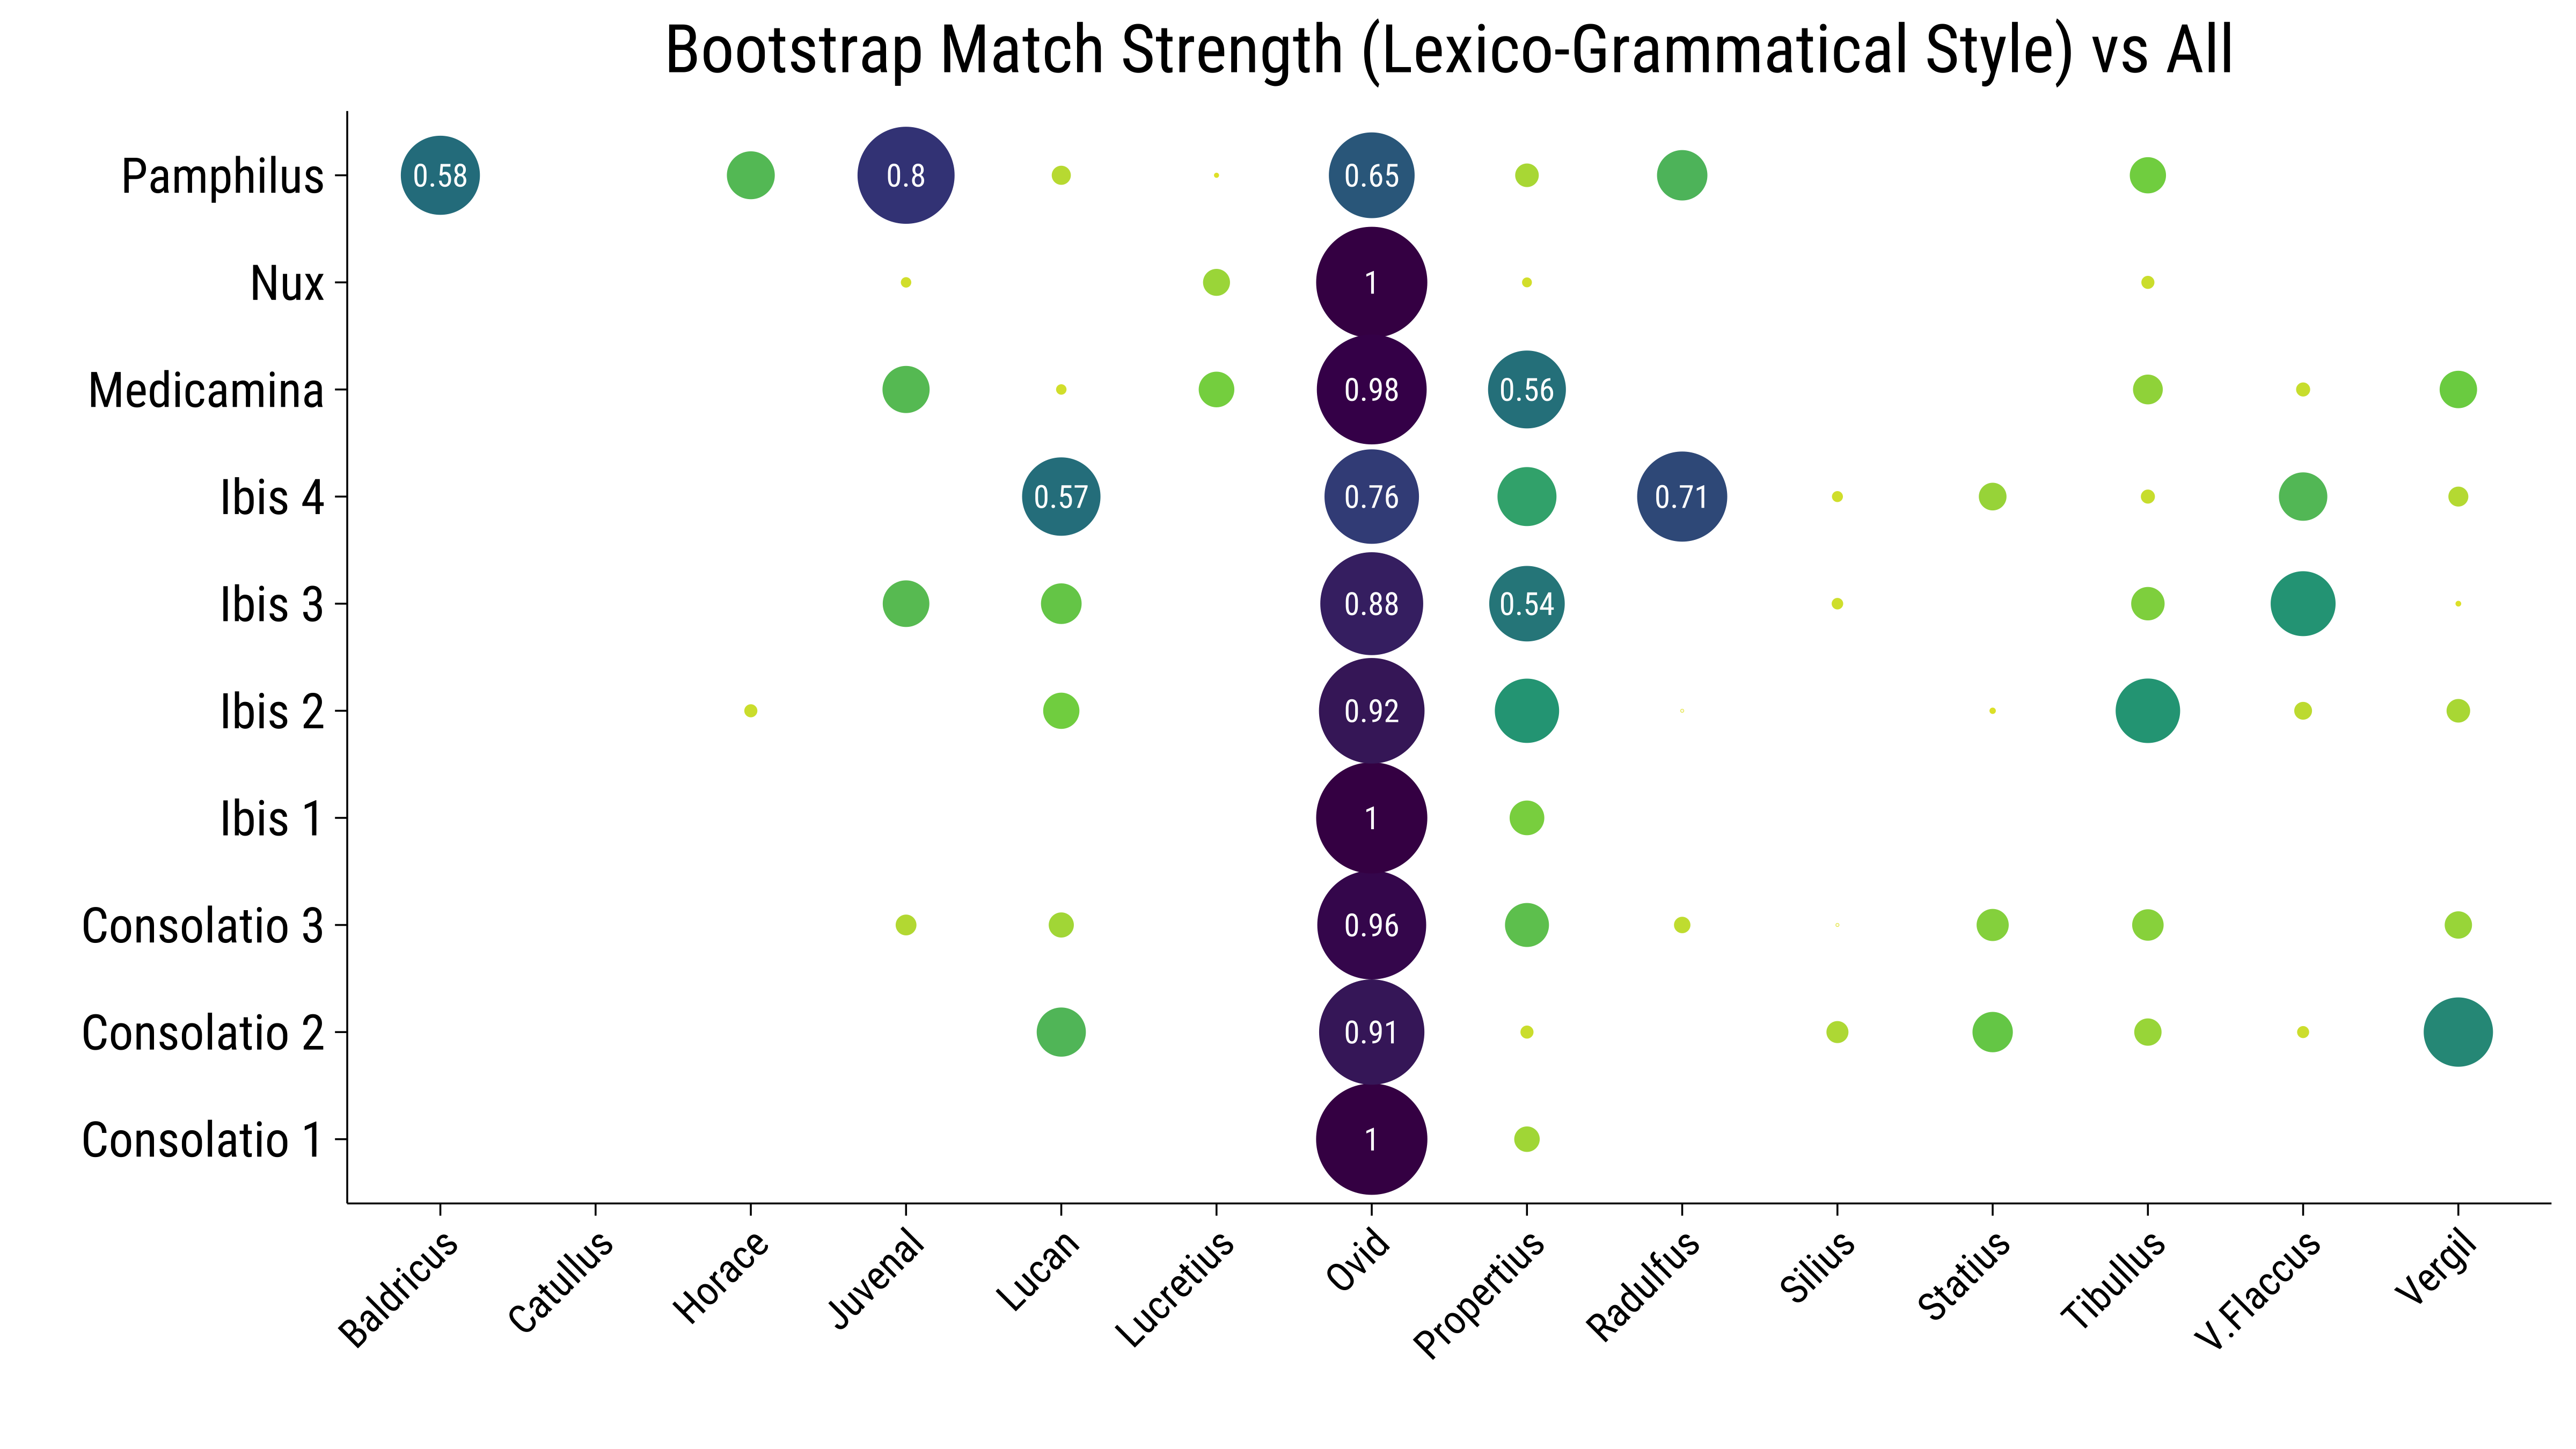

In [29]:
%%R -i bubble -h 4.5 -w 8 -u in -r 600
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
library(dplyr)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

data <- bubble
bgcol <- 'white'
fgcol <- 'black'

hi <- data %>% filter(Match > 0.5)

p <- ggplot(data=data, aes(x=Author, y=Work)) +
geom_point(aes(size=Match,color=Match)) +
geom_text(data=hi, aes(label=round(Match,2)),family='fnt',size=2.5, color=bgcol)+

scale_size(range = c(-3, 11)) + 
scale_color_viridis_c(direction = -1) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Match Strength (Lexico-Grammatical Style) vs All") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=9, family="fnt", color=fgcol, angle=45,hjust=1),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)

# fn <- "../figures/bdi_ngram_bubble.pdf"
# ggsave(plot=p, fn, dpi=600, width=8, height=4.5, device=cairo_pdf)
p


## BDI Distance Distribution Plot

In [18]:
# re-run the verification, to populate the _dist_arrays property

bdi_mm = BDIVerifier(
    metric="nini",
    nb_bootstrap_iter=1000,
    rnd_prop=0.35,
    random_state=np.random.default_rng(42),
)

bdi_mm.fit(scaled_X, labels)

bdi_mm.predict_proba(
    scaled_probs_X,
    [label_uniques.get_loc("Ovid")] * scaled_probs_X.shape[0],
    nb_imposters=50,
)

array([1.   , 0.985, 0.772, 1.   , 0.969, 0.977, 1.   , 0.965, 0.924,
       0.851])

In [19]:
ovid_df = pd.DataFrame(dict(zip(problems.Poem, bdi_mm._dist_arrays)))
ovid_df

,Nux,Medicamina,Pamphilus,Consolatio 1,Consolatio 2,Consolatio 3,Ibis 1,Ibis 2,Ibis 3,Ibis 4
0,0.081852,0.039518,0.058091,0.120929,0.093138,0.053328,0.109037,0.046915,-0.000541,0.076124
1,0.072557,0.050344,0.020935,0.116593,0.013215,0.028039,0.081020,0.054873,0.067925,0.063067
2,0.105342,0.056282,-0.033276,0.071681,0.060544,0.065783,0.095028,0.116434,0.080566,0.001592
3,0.072083,0.049477,-0.026216,0.016404,0.010607,0.038192,0.084783,0.033129,0.004878,0.028922
4,0.059587,0.047642,-0.006206,0.103380,0.086517,0.032921,0.118458,0.063194,-0.006893,-0.009083
...,...,...,...,...,...,...,...,...,...,...
995,0.113137,0.060483,0.049291,0.126961,0.072735,0.013638,0.119436,0.054818,0.068312,0.032007
996,0.093168,0.056770,0.004732,0.041982,0.074409,0.055764,0.108274,0.064743,0.036790,0.024894
997,0.049443,0.061575,0.003808,0.099294,0.069229,0.050653,0.056490,0.078097,0.086431,0.067497
998,0.078683,0.078451,0.028544,0.084073,0.058345,0.033928,0.075985,0.045307,0.049418,0.083287


In [20]:
ovid_df.apply(
    lambda x: f"{sp.stats.percentileofscore(x, 0):.2f}% of bootstrap runs with negative distance"
)

Nux              0.00% of bootstrap runs with negative distance
Medicamina       1.50% of bootstrap runs with negative distance
Pamphilus       22.80% of bootstrap runs with negative distance
Consolatio 1     0.00% of bootstrap runs with negative distance
Consolatio 2     3.10% of bootstrap runs with negative distance
Consolatio 3     2.30% of bootstrap runs with negative distance
Ibis 1           0.00% of bootstrap runs with negative distance
Ibis 2           3.50% of bootstrap runs with negative distance
Ibis 3           7.60% of bootstrap runs with negative distance
Ibis 4          14.90% of bootstrap runs with negative distance
dtype: object

In [21]:
# for ggplot for this kind of plot it is easier to have 'long' tables, so we
# melt the dataframe so each observation for each text is a 'variable'. We add a
# column just so we can highlight the _Consolatio_ in a different colour.

ridge_df = pd.melt(ovid_df.T.reset_index(), id_vars="index")
ridge_df["highlight_color"] = "a"
ridge_df.loc[ridge_df["index"].str.startswith("Con"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Pamp"), "highlight_color"] = "b"
ridge_df.loc[ridge_df["index"].str.startswith("Nux"), "highlight_color"] = "c"
ridge_df.head()

,index,variable,value,highlight_color
0,Nux,0,0.081852,c
1,Medicamina,0,0.039518,a
2,Pamphilus,0,0.058091,b
3,Consolatio 1,0,0.120929,b
4,Consolatio 2,0,0.093138,b


Picking joint bandwidth of 0.00559


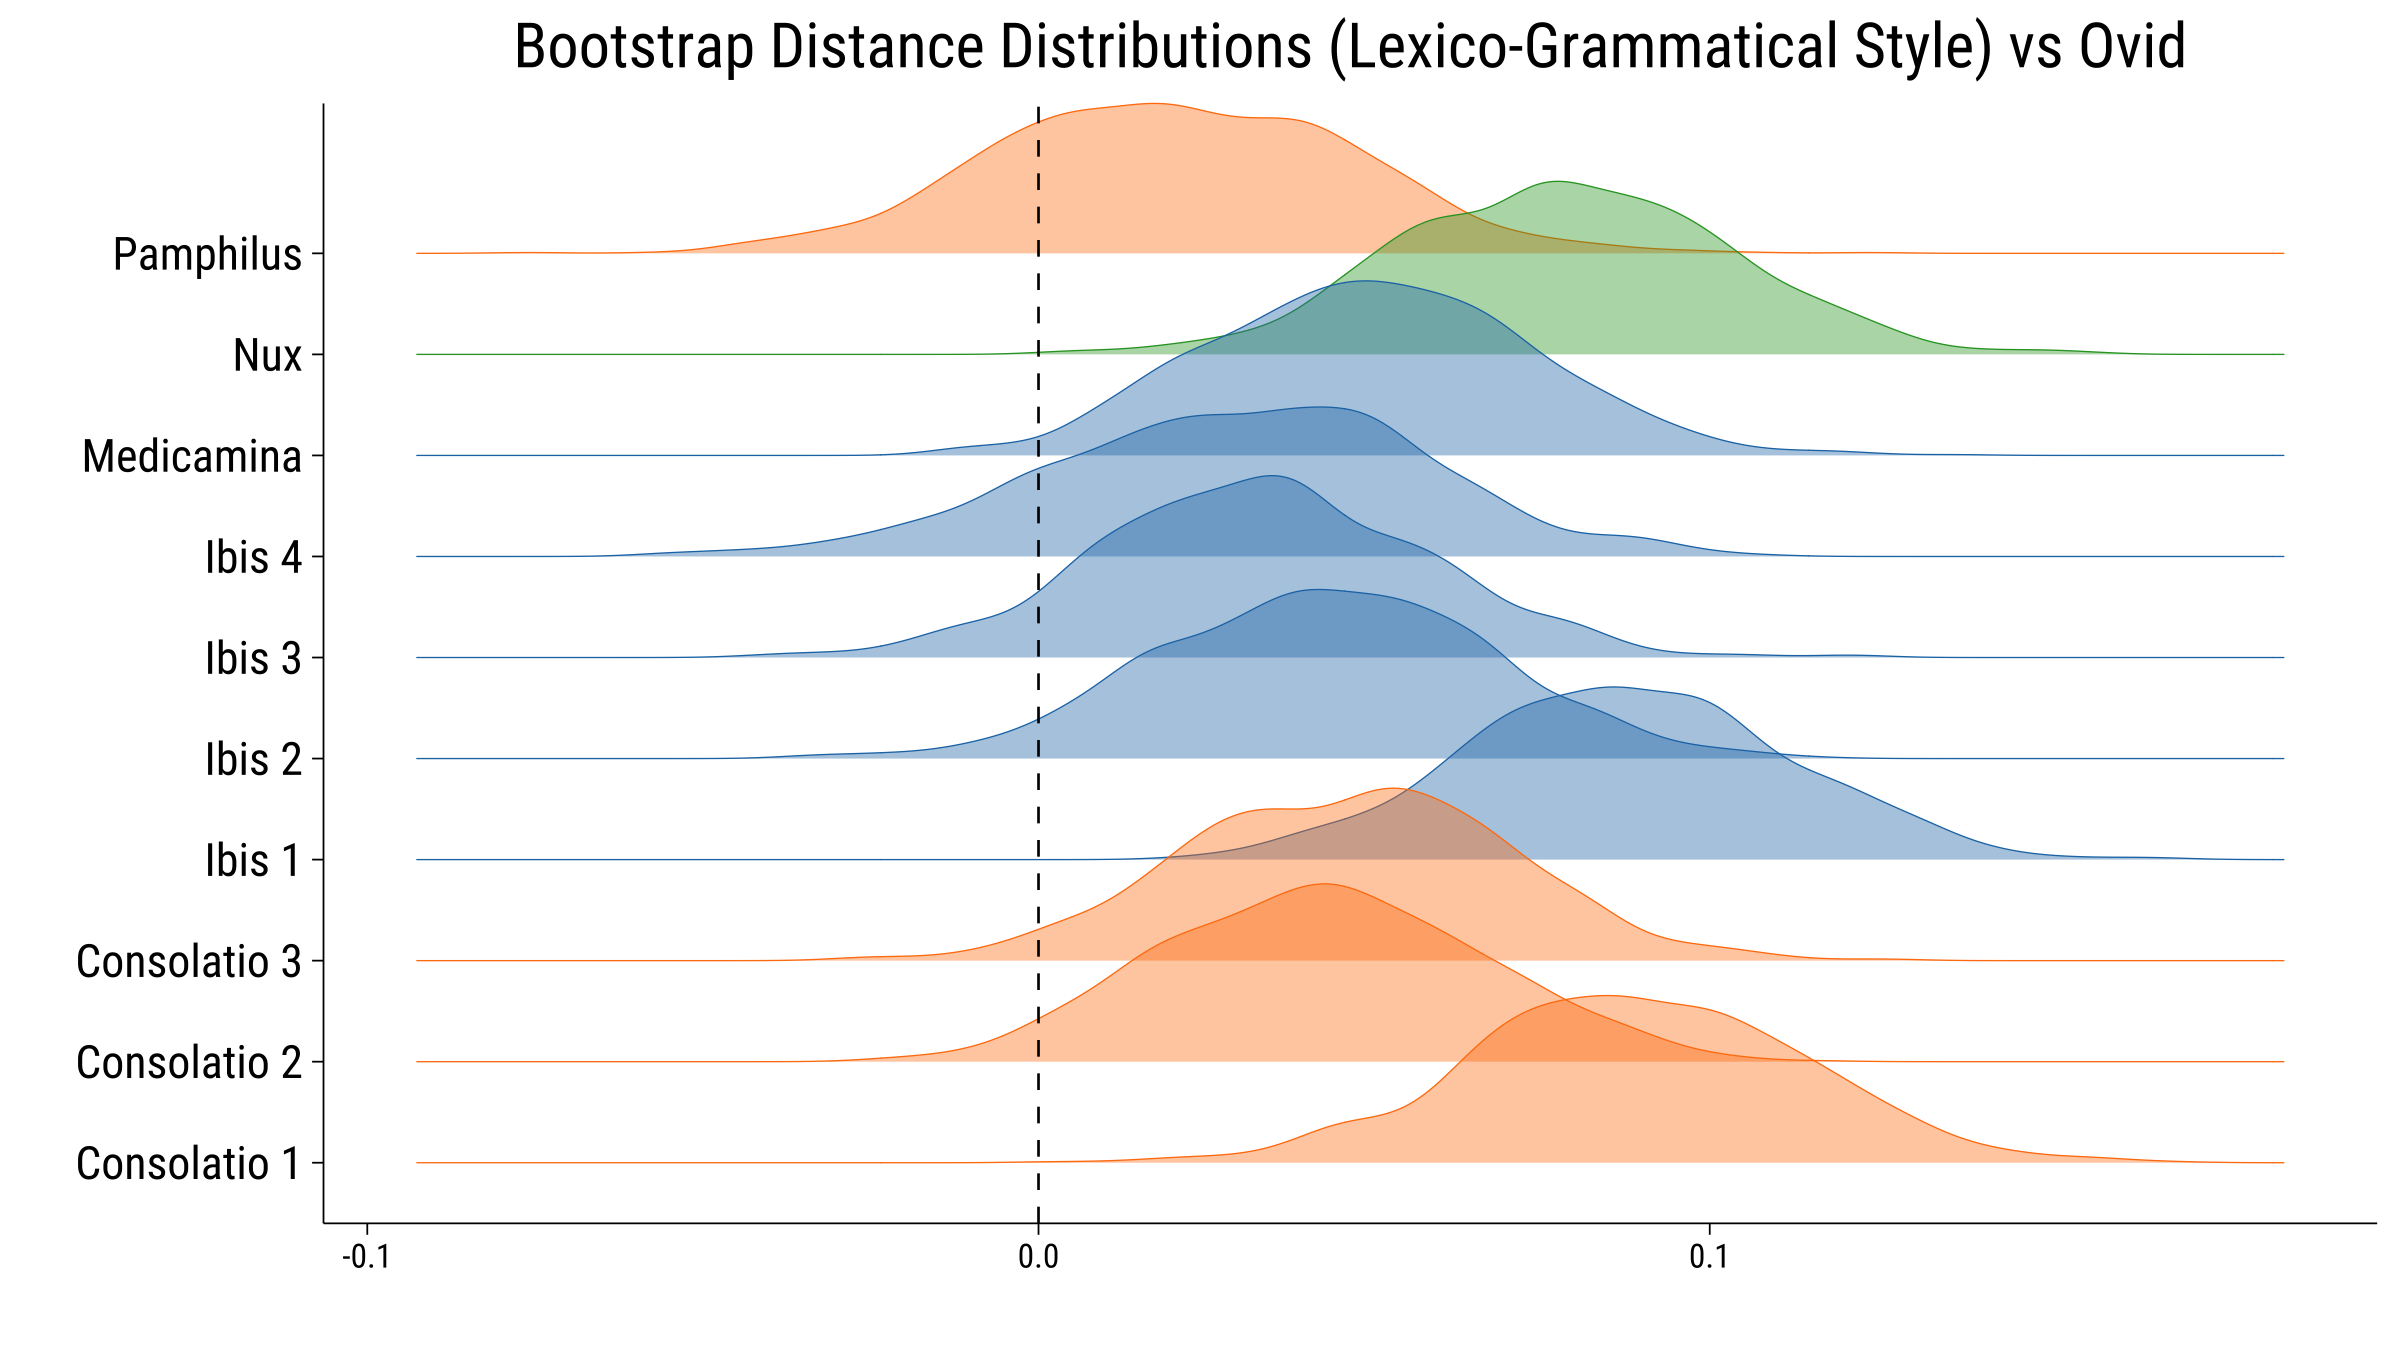

In [31]:
%%R -i ridge_df -h 4.5 -w 8 -u in -r 300
library(ggridges)
library(paletteer)
library(ggplot2)
library(showtext)
font_add_google("Roboto Condensed", "fnt")
showtext_auto()

plt <- "ggsci::category10_d3"
bgcol <- 'white'
fgcol <- 'black'
data <- ridge_df

p <- ggplot(data=data,aes(value,y=index,fill=highlight_color,color=highlight_color)) +
coord_cartesian(clip = "off") +

ggridges::stat_density_ridges(
    quantile_lines = FALSE, quantiles = 2, 
    alpha = .4,
    linewidth=0.15
) +
geom_vline(xintercept=0, colour=fgcol, linetype='dashed', linewidth=0.3) +
scale_y_discrete() +
scale_color_paletteer_d(plt) +
scale_fill_paletteer_d(plt) +
theme_bw() +
xlab("") +
ylab("") +
ggtitle("Bootstrap Distance Distributions (Lexico-Grammatical Style) vs Ovid") +
theme(
    panel.border = element_blank(),
    legend.position='none',
    panel.background = element_rect(fill = bgcol,color=bgcol),
    plot.background = element_rect(fill = bgcol,color=bgcol),
    plot.title = element_text(hjust = 0.5, size=15, family="fnt", color=fgcol),
    axis.line.x=element_line(linewidth=0.2,color=fgcol),
    axis.line.y=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.x=element_line(linewidth=0.2,color=fgcol),
    axis.ticks.y=element_line(linewidth=0.2,color=fgcol),
    axis.text.x=element_text(size=8, family="fnt", color=fgcol),
    axis.text.y=element_text(size=11, family="fnt", color=fgcol),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
)


# fn <- "../figures/bdi_ngram.pdf"
# ggsave(plot=p, fn, dpi=600, width=8, height=4.5, device=cairo_pdf)
p

In [23]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 20 2025

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.20.0

numpy  : 1.26.4
sklearn: 1.4.2
ruzicka: 1.1.0
scipy  : 1.13.0
pandas : 2.2.2

Watermark: 2.5.0

